# Disalignment performance degradation
With this notebook, we compare the performances of the various BondiNets with varying strides values in the first layer when misaligning the JPEG test samples of 1 pixel at at time in the diagonal direction.  

## Libraries import

In [1]:
# Sys libraries
import os
import glob
import sys
sys.path.append('../')
from tqdm.notebook import tqdm

# Plotting libraries
import matplotlib.pyplot as plt
import numpy as np
# SETTING THE PLOT parameters to the ACM font
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Linux Libertine O'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{libertine}'
]

%matplotlib inline

# Torch and data libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import SubsetRandomSampler, SequentialSampler, DataLoader
from isplutils.data import CustomBlockJPEGBalancedDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from architectures import fornet
from architectures.fornet import FeatureExtractor, create_model

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_2246748/1967353216.py:16: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [


## Helpers functions and classes

In [2]:
def bin_acc(y_pred, y_test) -> float:
    y_pred_sig = torch.sigmoid(y_pred)
    y_pred_tags = y_pred_sig > 0.5
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc *= 100
    return acc


def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.nn.functional.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc) * 100
    return acc


def batch_forward(net: torch.nn.Module, device, criterion,
                  data: torch.Tensor, labels: torch.Tensor) -> (torch.Tensor, float):
    if torch.cuda.is_available():
        data = data.to(device)
        labels = labels.to(device)
    out = net(data).squeeze()
    loss = criterion(out, labels)
    pred = torch.sigmoid(out)
    return loss, pred


def balanced_collate_fn(batch):
    return [torch.cat([elem[0] for elem in batch]), torch.cat([elem[1] for elem in batch])]


def samples_idx_mapper(sample_idx: int) -> int:
    return sample_idx//2

## Execution parameters

In [3]:
models_dir = '../models/BondiNets'
gpu_id = 2
precomputed = True  # whether to use the precomputed results or let the notebook do the job
data_root = '../data'  # PLACE HERE THE DIRECTORY WHERE YOU SAVED THE DATASETS!

### Let's build a dictionary with all the models divided by JPEG factor

In [4]:
all_jpeg_dirs = os.listdir(models_dir)
models_paths = dict()
for jpeg_dir in all_jpeg_dirs:
    jpeg_bs = int(jpeg_dir.split('x')[0])
    models_paths[jpeg_bs] = glob.glob(os.path.join(models_dir, jpeg_dir, '*/bestval.pth'))

## Let's start
We are gonna cycle over all models and compute the test results first.  
We are going to find the correctly classified samples, and then meausure the deviation of the performances as a function of the diagonal displacement.

In [5]:
all_jpegs = []
if os.path.exists('BondiNets_displacement_results.pkl') and precomputed:
    print('Results already computed!')
    all_jpegs = pd.read_pickle('BondiNets_displacement_results.pkl')
else:

    for jpeg_bs in models_paths.keys():
        all_models_disp_df = []

        for model_path in models_paths[jpeg_bs]:

            print(f'Displacing along diagonal direction...')
            test_dfs = dict()
            
            # Parse useful params from the model path
            split_seed = int(model_path.split('split_seed-')[1].split('_')[0])
            p_train_test = float(model_path.split('train_test-')[1].split('_')[0])
            p_train_val = float(model_path.split('train_val-')[1].split('_')[0])
            net_name = model_path.split('net-')[1].split('_')[0]
            in_channels = int(model_path.split('in_channels-')[1].split('_')[0])
            batch_size = 1
            fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
            jpeg_bs = int(model_path.split('jpeg_bs-')[1].split('_')[0])
            patch_size = fl_stride*64

            # Set the device
            device = f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu'
            
            # Create net
            params = {'in_channels': in_channels, 'num_classes': 1, 'first_layer_stride': fl_stride,
                  'first_layer_kernel': 0, 'fl_mean_pool': False, 'pool_only': False}
            net = create_model(net_name, params, device)
            net = net.eval()

            # load model
            print(f'Loading model {model_path}...')
            state_tmp = torch.load(model_path, map_location='cpu')
            if 'net' not in state_tmp.keys():
                state = OrderedDict({'net': OrderedDict()})
                [state['net'].update({'model.{}'.format(k): v}) for k, v in state_tmp.items()]
            else:
                state = state_tmp
            incomp_keys = net.load_state_dict(state['net'], strict=True)
            print(incomp_keys)
            print('Model loaded!')

            test_dfs = []
            for disp in range(jpeg_bs+1):

                # Load the data
                dataset = CustomBlockJPEGBalancedDataset(data_root=data_root, 
                                                         patch_size=patch_size, 
                                                         transforms=A.Compose([ToTensorV2()]),
                                                         grayscale=in_channels==1, 
                                                         disaligned_grid_patch=[disp, disp],
                                                         jpeg_bs=jpeg_bs)
                # Split in training, validation and test
                dataset_idxs = list(range(len(dataset)))
                np.random.seed(split_seed)  # setting the seed for training-test split
                np.random.shuffle(dataset_idxs)
                test_split_index = int(np.floor((1 - p_train_test) * len(dataset)))
                train_val_idxs, test_idxs = dataset_idxs[test_split_index:], dataset_idxs[:test_split_index]
                val_split_index = int(np.floor((1 - p_train_val) * len(train_val_idxs)))
                train_idx, val_idx = train_val_idxs[val_split_index:], train_val_idxs[:val_split_index]
                
                # Let's consider the test set indexes only
                test_idxs = np.array(test_idxs)
                test_sampler = SequentialSampler(test_idxs)
                test_dl = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4, shuffle=False, drop_last=False,
                                       sampler=test_sampler, collate_fn=balanced_collate_fn,)


                # --- TEST LOOP
                test_df = pd.DataFrame(index=np.arange(len(test_idxs)*2))
                test_df['bce_loss'] = 0.0
                test_df['pred'] = 0.0
                test_df['labels'] = False
                criterion = torch.nn.BCEWithLogitsLoss()
                test_loss = test_acc = test_num = 0
                for idx, batch_data in enumerate(tqdm(test_dl, desc='Test sample', leave=False, total=len(test_dl))):
                    # Fetch data
                    batch_img, batch_label = batch_data

                    with torch.no_grad():
                        # Forward pass
                        batch_loss, batch_pred = batch_forward(net, device, criterion, batch_img, batch_label)
                    
                    # Save statistics
                    test_df.loc[idx*2, 'bce_loss'] = batch_loss.detach().cpu().item()
                    test_df.loc[idx*2, 'labels'] = batch_label[0].detach().cpu().item()>0
                    test_df.loc[idx*2, 'pred'] = batch_pred[0].detach().cpu().item()
                    test_df.loc[idx*2+1, 'bce_loss'] = batch_loss.detach().cpu().item()
                    test_df.loc[idx*2+1, 'labels'] = batch_label[1].detach().cpu().item()>0
                    test_df.loc[idx*2+1, 'pred'] = batch_pred[1].detach().cpu().item()


                # Clean GPU memory
                torch.cuda.empty_cache()

                # Save the results in the bigger dictionary
                test_dfs.append(pd.concat({disp: test_df.copy()}, names=['Grid displacement']))

            # Save results in bigger dataframe
            all_disps_df = pd.concat(test_dfs)
            all_models_disp_df.append(pd.concat({model_path: all_disps_df}, names=['Model']))

        # Concatenate everything
        all_models_disp_df = pd.concat(all_models_disp_df)
        all_jpegs.append(pd.concat({jpeg_bs: all_models_disp_df}, names=['JPEG block size']))

    # Concatenate everything again
    all_jpegs = pd.concat(all_jpegs)
    # Save the results
    all_jpegs.to_pickle('BondiNets_displacement_results.pkl')

all_jpegs

Results already computed!


bce_loss  \
JPEG block size Model                                              Grid displacement                     
7               ../models/BondiNets/7x7_block_nets/net-BondiNet... 0                 0    5.960464e-08   
                                                                                     1    5.960464e-08   
                                                                                     2    4.301682e-03   
                                                                                     3    4.301682e-03   
                                                                                     4    7.437298e-02   
...                                                                                                ...   
12              ../models/BondiNets/12x12_block_nets/net-BondiN... 12                663  2.908624e-05   
                                                                                     664  0.000000e+00   
                                                                                     665  0.000000e+00   
                                                                                     666  1.796957e+00   
                                                                                     667  1.796957e+00   

                                                                                                  pred  \
JPEG block size Model                                              Grid displacement                     
7               ../models/BondiNets/7x7_block_nets/net-BondiNet... 0                 0    1.481298e-07   
                                                                                     1    1.000000e+00   
                                                                                     2    4.683889e-03   
                                                                                     3    9.960991e-01   
                                                                                     4    1.381936e-01   
...                                                                                                ...   
12              ../models/BondiNets/12x12_block_nets/net-BondiN... 12                663  9.999425e-01   
                                                                                     664  1.864525e-08   
                                                                                     665  1.000000e+00   
                                                                                     666  9.725094e-01   
                                                                                     667  9.999999e-01   

                                                                                          labels  
JPEG block size Model                                              Grid displacement              
7               ../models/BondiNets/7x7_block_nets/net-BondiNet... 0                 0     False  
                                                                                     1      True  
                                                                                     2     False  
                                                                                     3      True  
                                                                                     4     False  
...                                                                                          ...  
12              ../models/BondiNets/12x12_block_nets/net-BondiN... 12                663    True  
                                                                                     664   False  
                                                                                     665    True  
                                                                                     666   False  
                                                                                     667    True  

[106880 rows x 3 columns]

## Let's see plot some graphics

### 7x7 block JPEG images

In [6]:
block_size = 7

### Absolute Score Difference (ASD)

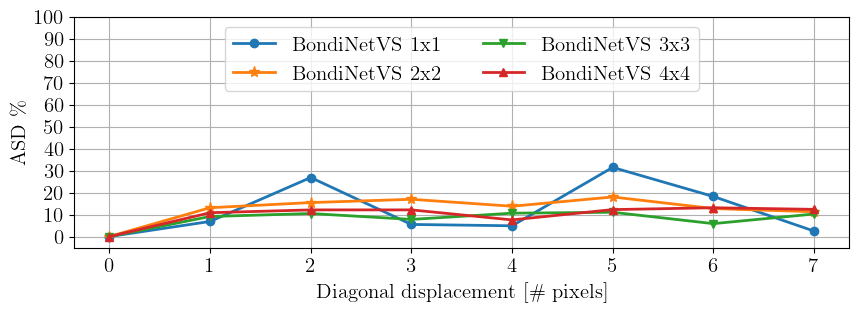

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
fontsize=20
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    pred_df = all_jpegs.loc[(block_size, model_path), 'pred']
    differences = []
    for disp in range(block_size+1):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    if markers[idx] == '*':
        axs.plot(differences, label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(differences, label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5, ncols=2, loc='upper center')
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(block_size+1))
plt.show()

### BCE loss

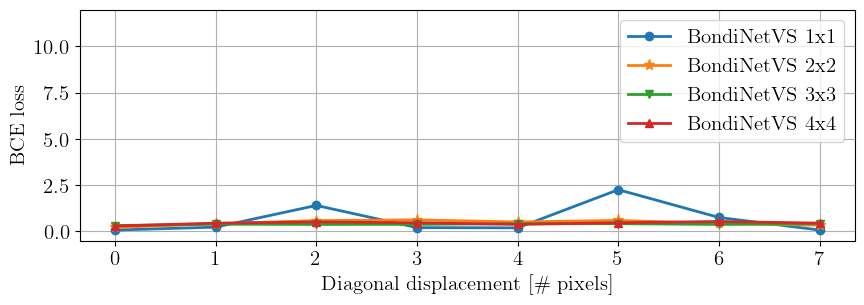

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    test_df = all_jpegs.loc[(block_size, model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    if markers[idx] == '*':
        axs.plot(mean_df['bce_loss'], label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(mean_df['bce_loss'], label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5)
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-0.5, 12])
plt.show()

### 8x8 block JPEG images

In [20]:
block_size = 8

### Absolute Score Difference (ASD)

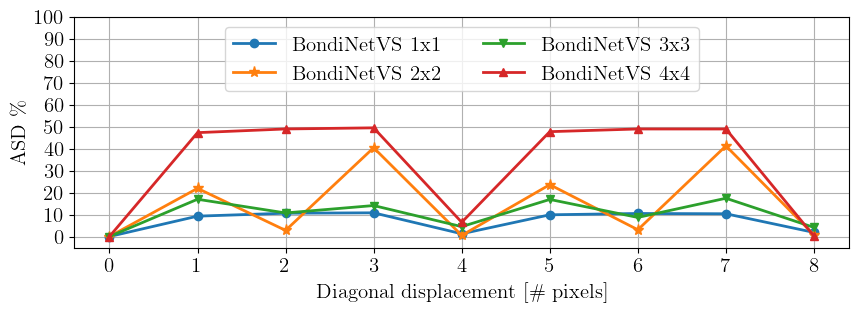

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
fontsize=20
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    pred_df = all_jpegs.loc[(block_size, model_path), 'pred']
    differences = []
    for disp in range(block_size+1):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    if markers[idx] == '*':
        axs.plot(differences, label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(differences, label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5, ncols=2, loc='upper center')
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
#axs.set_title(f'{direction} displacement')
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(block_size+1))
plt.show()

### For the teaser

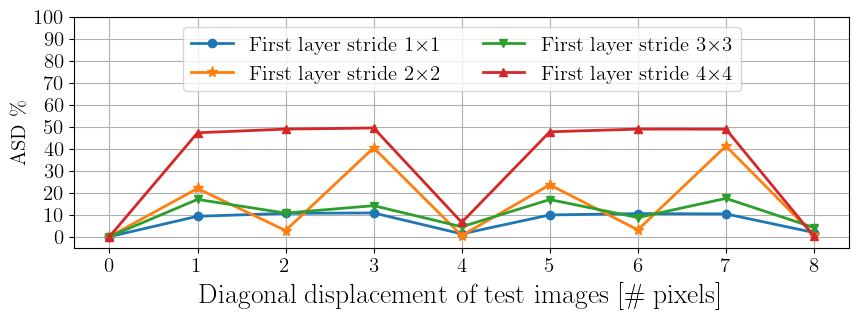

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
fontsize=20
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    pred_df = all_jpegs.loc[(block_size, model_path), 'pred']
    differences = []
    for disp in range(block_size+1):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    if markers[idx] == '*':
        axs.plot(differences, label=fr'First layer stride {fl_stride}$\times${fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(differences, label=fr'First layer stride {fl_stride}$\times${fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5, ncols=2, loc='upper center')
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement of test images [\# pixels]', fontsize=fontsize)
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(block_size+1))
plt.show()

### BCE loss

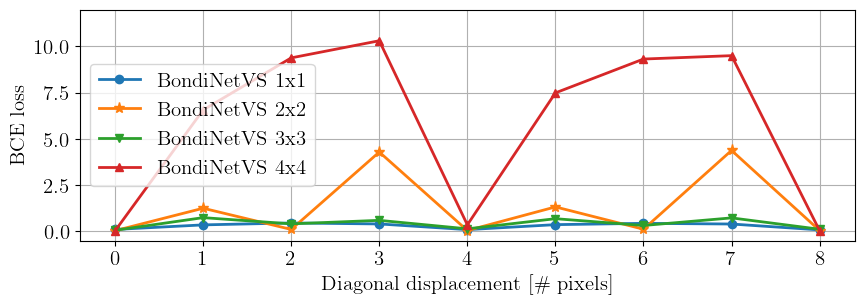

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    test_df = all_jpegs.loc[(block_size, model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    if markers[idx] == '*':
        axs.plot(mean_df['bce_loss'], label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(mean_df['bce_loss'], label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5)
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-0.5, 12])
plt.show()

### For the teaser

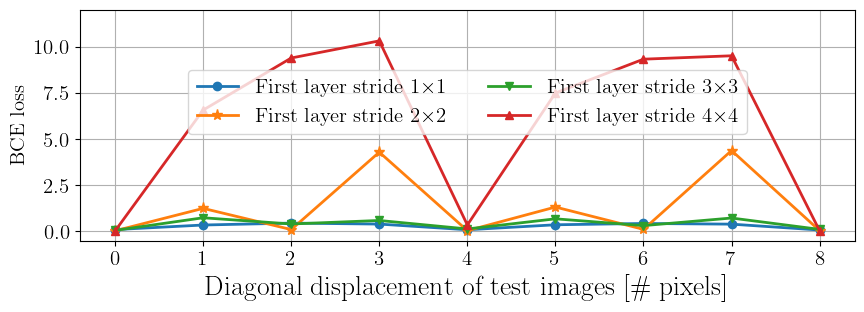

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    test_df = all_jpegs.loc[(block_size, model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    if markers[idx] == '*':
        axs.plot(mean_df['bce_loss'], label=fr'First layer stride {fl_stride}$\times${fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(mean_df['bce_loss'], label=fr'First layer stride {fl_stride}$\times${fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5, ncols=2, loc='center', bbox_to_anchor=(0.5, 0.6))
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement of test images [\# pixels]', fontsize=fontsize)
axs.grid('on')
axs.set_ylim([-0.5, 12])
plt.show()

### 9x9 block JPEG images

In [27]:
block_size = 9

### Absolute Score Difference (ASD)

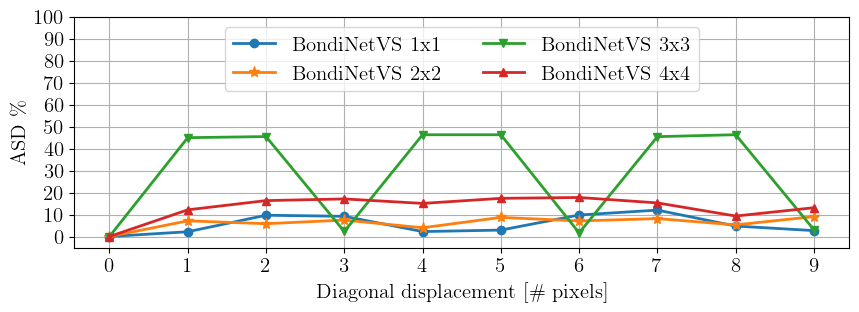

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
fontsize=20
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    pred_df = all_jpegs.loc[(block_size, model_path), 'pred']
    differences = []
    for disp in range(block_size+1):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    if markers[idx] == '*':
        axs.plot(differences, label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(differences, label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5, ncols=2, loc='upper center')
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(block_size+1))
plt.show()

### BCE loss

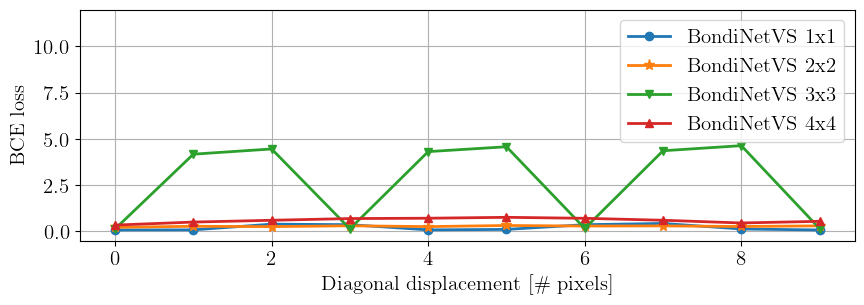

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    test_df = all_jpegs.loc[(block_size, model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    if markers[idx] == '*':
        axs.plot(mean_df['bce_loss'], label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(mean_df['bce_loss'], label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5)
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-0.5, 12])
plt.show()

### 12x12 block JPEG images

In [30]:
block_size = 12

### Absolute Score Difference (ASD)

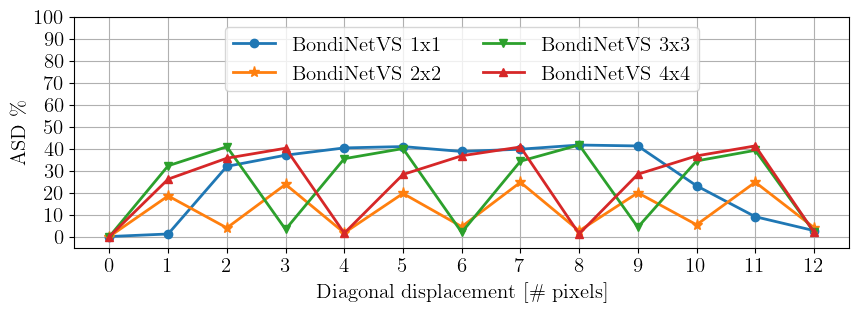

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
fontsize=20
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    pred_df = all_jpegs.loc[(block_size, model_path), 'pred']
    differences = []
    for disp in range(block_size+1):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    if markers[idx] == '*':
        axs.plot(differences, label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(differences, label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5, ncols=2, loc='upper center')
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(block_size+1))
plt.show()

### BCE loss

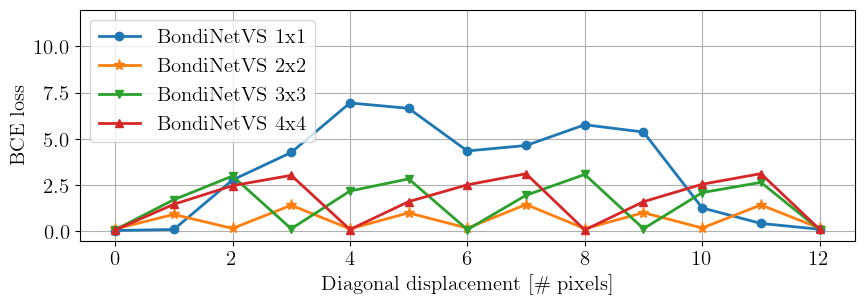

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
markers = ['o', '*', 'v', '^']
for idx, model_path in enumerate(models_paths[block_size]):
    fl_stride = int(model_path.split('fl_stride-')[1].split('_')[0])
    test_df = all_jpegs.loc[(block_size, model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    if markers[idx] == '*':
        axs.plot(mean_df['bce_loss'], label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=8)
    else:
        axs.plot(mean_df['bce_loss'], label=f'BondiNetVS {fl_stride}x{fl_stride}', marker=markers[idx], linewidth=2,
                markersize=6)
axs.legend(fontsize=fontsize-5)
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-0.5, 12])
plt.show()

## Credits
[Image and Sound Processing Lab (ISPL)](http://ispl.deib.polimi.it/)
- Edoardo Daniele Cannas;
- Sara Mandelli;
- Paolo Bestagini;
- Stefano Tubaro.